In [33]:
# Standard library imports
import os
import sys
import json
import traceback
import pickle
import uuid
from datetime import datetime, timezone
from io import StringIO, BytesIO

# Third-party imports - Data and Visualization
import pandas as pd
import sklearn
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from IPython.display import display, Markdown, HTML, Image

# LangChain imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode


In [34]:
# Custom state Class that is going to be used to store the messages and tool results
from dataclasses import dataclass, field
from typing import List, Any, Dict

@dataclass
class MessagesStateWithTools(MessagesState):
    tool_results: List[Dict] = field(default_factory=list)

In [35]:
# Loading the CSV to make sure the right variable is passed to the agent.
csv_file_path = "loan_data.csv"
df = pd.read_csv(csv_file_path)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [36]:
system_message = """
You are an advanced AI assistant equipped with tools, including a Python execution tool called `python_repl`.
The pandas dataframe is called `df` and is already provided for you to work on.

## TOOL CALL RULES (IMPORTANT)
1. When you need to execute Python code, you MUST call the `python_repl` tool.
2. The arguments for python_repl must include:
   {"code": "<python code>", "thoughts": "<brief internal intention>"}
3. After producing a tool call, you MUST wait for the tool result message before producing any user-facing content.

- Do as many tool call as you need to inspect the dataframe columns and get the analysis.
BEFORE doing ANY analysis, you MUST first inspect the dataframe columns.
(important) FIRST TOOL CALL - Inspection only (inspect the dataframe columns to know more about the data)
- **TO SEE CODE OUTPUT**, use `print()` statements. You won't be able to see outputs of `pd.head()`, `pd.describe()` etc. otherwise.
SECOND TOOL CALL - Analysis using EXACT column names from the inspection:
- Do NOT guess or assume column names
- If the column doesn't exist, tell the user
- NEVER WRITE: plotly_figures = [], The variable plotly_figures is ALREADY INITIALIZED for you.
-ONLY write: plotly_figures.append(fig)

## GENERAL BEHAVIOR
- Only do what you can with the data provided
- Always answer clearly with correct reasoning
- If the tool produces an error, explain it and suggest corrections
- Human-readable messages appear only AFTER tool results
- Always inspect dataframe columns BEFORE any analysis

## PLOTTING AND LIBRARIES
- Always use the `plotly` library for plotting
- Do NOT call fig.show() - instead append to plotly_figures: plotly_figures.append(fig)
- AVAILABLE LIBRARIES: pandas (as pd), sklearn, plotly (px, go, pio) - all already imported
- For sklearn, import specific modules as needed, e.g.: from sklearn.model_selection import train_test_split
"""

In [37]:
#Helper functions with general usage
def clean_code_string(code: str) -> str:
    """
    Clean code string by:
    1. Unescaping newlines and other escape sequences
    2. Removing markdown code blocks
    """
    # Strip markdown code blocks if present FIRST
    code = code.strip()
    if code.startswith("```"):
        lines = code.split("\n")
        # Remove first line (```python or ```)
        if lines[0].startswith("```"):
            lines = lines[1:]
        # Remove last line if it's ```
        if lines and lines[-1].strip() == "```":
            lines = lines[:-1]
        code = "\n".join(lines).strip()
        
    # Now handle escape sequences
    # Replace escaped newlines with actual newlines
    code = code.replace('\\n', '\n') 
    # Replace escaped tabs with actual tabs
    code = code.replace('\\t', '\t')
    # Replace escaped quotes
    code = code.replace("\\'", "'")
    code = code.replace('\\"', '"')
    # Replace escaped backslashes
    code = code.replace('\\\\', '\\')
    
    return code
    
from typing import Tuple

def extract_code_and_thoughts(last_message, tc=None) -> Tuple[str, str]:
    """
    Extract code and thoughts from LLM message or tool call.
    
    Args:
        last_message: Message object or dict from LLM
        tc: Tool call dict (optional)
    
    Returns:
        Tuple of (code: str, thoughts: str)
    """
    # Try tool call first (most common case)
    if tc and isinstance(tc, dict):
        args = tc.get("args") or tc.get("arguments", {})
        
        # If args is a dict, extract directly
        if isinstance(args, dict):
            code = args.get("code", "") or ""
            thoughts = args.get("thoughts", "") or ""
            return code, thoughts
        
        # If args is a JSON string, parse it
        if isinstance(args, str) and args.strip():
            try:
                parsed = json.loads(args)
                if isinstance(parsed, dict):
                    code = parsed.get("code", "") or ""
                    thoughts = parsed.get("thoughts", "") or ""
                    return code, thoughts
            except json.JSONDecodeError:
                # Treat as raw code
                return args, ""
    
    # Try last_message function_call (fallback)
    if isinstance(last_message, dict):
        func = last_message.get("additional_kwargs", {}).get("function_call")
        if isinstance(func, dict):
            args_json = func.get("arguments", "")
            if args_json and isinstance(args_json, str):
                try:
                    parsed = json.loads(args_json)
                    if isinstance(parsed, dict):
                        code = parsed.get("code", "") or ""
                        thoughts = parsed.get("thoughts", "") or ""
                        return code, thoughts
                except json.JSONDecodeError:
                    pass
    
    # Nothing found
    return "", ""

In [38]:
def python_repl(code: str, thoughts: str) -> dict:
    """
    Execute Python code and return:
      { stdout: str, result: any or None, figures: [paths], error: str or None }
    """
    code = clean_code_string(code)
    os.makedirs("images/plotly_figures/pickle", exist_ok=True)
    saved_figures = []
    stdout_buf = StringIO()
    
    original_stdout = sys.stdout
    try:
        sys.stdout = stdout_buf
        
        env_vars = {
            "__builtins__": __builtins__,
            "df": df,
            "pd": pd,           
            "px": px,           
            "go": go,           
            "pio": pio,        
            "sklearn": sklearn, 
            "plotly_figures": []
        }
        exec(code, env_vars, env_vars)

        for fig in env_vars.get("plotly_figures", []):
            fname = f"images/plotly_figures/pickle/{uuid.uuid4()}.pickle"
            with open(fname, "wb") as f:
                pickle.dump(fig, f)
            saved_figures.append(fname)

        stdout_val = stdout_buf.getvalue()
        result_val = env_vars.get("result", None)

        return {
            "stdout": stdout_val or "",
            "result": result_val,
            "figures": saved_figures,
            "error": None
        }
    except Exception as e:
        tb = traceback.format_exc()
        return {
            "stdout": stdout_buf.getvalue() or "",
            "result": None,
            "figures": saved_figures,
            "error": tb
        }
    finally:
        sys.stdout = original_stdout

In [ ]:
def tools_node(state: MessagesStateWithTools) -> dict:
    """
    Look at the last LLM message for tool_calls and execute them in order.
    Store raw tool_result dicts in state["tool_results"] for later formatting.
    Return ToolMessages so the LLM can see the results.
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # Get existing tool_results or start with empty list - DEFINE THIS EARLY!
    existing_results = state.get("tool_results") if isinstance(state.get("tool_results"), list) else []
    tool_results = existing_results.copy() if existing_results else []
    
    # Robustly extract tool_calls from a message object or dict
    tool_calls = []
    try:
        tool_calls = getattr(last_message, "tool_calls", None) or []
    except Exception:
        tool_calls = []

    if not tool_calls and isinstance(last_message, dict):
        tool_calls = last_message.get("tool_calls", []) or []

    if not tool_calls:
        return {"messages": [], "tool_results": tool_results}  # Return tool_results here too!

    tool_messages = []
    for tc in tool_calls:
        name = tc.get("name") if isinstance(tc, dict) else getattr(tc, "name", None)
        tool_call_id = tc.get("id") if isinstance(tc, dict) else getattr(tc, "id", str(uuid.uuid4()))

        code, thoughts = extract_code_and_thoughts(last_message, tc)
        code = code or ""
        thoughts = thoughts or ""

        if name == "python_repl":
            tool_result = python_repl(code=code, thoughts=thoughts)
        else:
            tool_result = {"stdout": "", "result": None, "figures": [], "error": f"Unknown tool: {name}"}

        # Store the raw result for later display formatting
        normalized = {
            "type": "tool_result",
            "tool": name,
            "stdout": tool_result.get("stdout", "") or "",
            "result": tool_result.get("result", None),
            "figures": tool_result.get("figures", []) or [],
            "error": tool_result.get("error", None),
            "timestamp": datetime.now(timezone.utc).isoformat(),
            "_structured": False
        }
        tool_results.append(normalized)
        
        # Format the result as a readable string for the LLM
        result_parts = []
        
        if tool_result.get("stdout"):
            result_parts.append(f"STDOUT:\n{tool_result['stdout']}")
        
        if tool_result.get("result") is not None:
            result_parts.append(f"RESULT:\n{tool_result['result']}")
        
        if tool_result.get("figures"):
            for fig_path in tool_result["figures"]:
                result_parts.append(f"FIGURE SAVED: {fig_path}")
        
        if tool_result.get("error"):
            result_parts.append(f"ERROR:\n{tool_result['error']}")
        
        content = "\n\n".join(result_parts) if result_parts else "Tool execution completed successfully."
        
        # Create ToolMessage so the LLM can see the results
        tool_msg = ToolMessage(
            content=content,
            tool_call_id=tool_call_id,
            name=name
        )
        
        tool_messages.append(tool_msg)
    return {"messages": tool_messages, "tool_results": tool_results}

SyntaxError: invalid syntax (2598408634.py, line 52)

In [40]:
def store_response(state: MessagesStateWithTools) -> dict:
    """
    Capture the AI's final message after tool execution and store it in tool_results.
    This allows displaying tool results and AI responses in order.
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    content = ""
    if hasattr(last_message, "content"):
        content = last_message.content
    elif isinstance(last_message, dict):
        content = last_message.get("content", "")
    
    ai_message_result = {
        "type": "ai_message",
        "content": content,
        "timestamp": datetime.now(timezone.utc).isoformat(),
        "_structured": False
    }
    
    state.setdefault("tool_results", [])
    state["tool_results"].append(ai_message_result)

    return {}

In [41]:
def call_agent(state) -> dict:
    """
    Call the LLM with tools. Expects 'state["messages"]' to be a list of message objects or dicts.
    Ensures the system message is present at the front.
    Returns the LLM response message object.
    """
    messages = state["messages"]
    # Check if system message already exists
    has_system = any(isinstance(m, SystemMessage) for m in messages)
    
    if not has_system:
        messages = [SystemMessage(content=system_message)] + messages
    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state)-> str:
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    
    # Check if there were previous tool results (meaning this is a response after tool execution)
    if state.get("tool_results") and len(state["tool_results"]) > 0:
        # Check if the last tool_result is not already an AI message
        if state["tool_results"][-1].get("type") != "ai_message":
            return "store_response"
    return END

In [59]:
python_repl_schema = {
    "name": "python_repl",
    "description": (
        "Execute Python code for data analysis and visualization. "
        "The code may read a pre-populated DataFrame called `df`. "
        "If you create Plotly figures, append them to the list `plotly_figures` "
        "so the execution environment can capture them. "
        "If you want to return a value, assign it to the variable `result`."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "code": {
                "type": "string",
                "description": "Python code to execute. Must not call fig.show(); use plotly_figures.append(fig)."
            },
            "thoughts": {
                "type": "string",
                "description": "Optional: agent's private reasoning or intent (not shown to user)."
            },
        },
        "required": ["code"]
    }
}
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    google_api_key=os.getenv("GOOGLE_API_KEY")
)
llm_with_tools = llm.bind_tools([python_repl_schema])

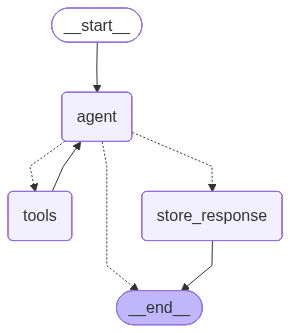

In [60]:
workflow = StateGraph(MessagesStateWithTools)

workflow.add_node("agent", call_agent)
workflow.add_node("tools", tools_node)
workflow.add_node("store_response", store_response)  # New node!

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", "store_response", END])
workflow.add_edge("tools", "agent")
workflow.add_edge("store_response", END)  # After storing response, end the workflow

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
def run_query(query: str, thread_id: str = "default"):
    """Run a query and display results."""
    config = {"configurable": {"thread_id": thread_id}}
    
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print(f"{'='*60}\n")
    
    result = graph.invoke(
        {
            "messages": [HumanMessage(content=query)],
        },
        config=config
    )
    
   
    final_message = result["messages"][-1]
    # Extract the content from the message
    content = final_message.content if hasattr(final_message, 'content') else str(final_message)
    # Display as markdown
    display(Markdown(content))
    print(f"\nResponse: {final_message}\n")

In [71]:
run_query("give me a dif report about the data with at least 5 visualizations that you never did before")


Query: give me a dif report about the data with at least 5 visualizations that you never did before



Here is a report about the data, featuring five new visualizations that have not been presented before:

**Data Overview:**
The dataset comprises 614 entries and 13 columns, detailing loan application information. Key columns include demographic and financial attributes such as 'Dependents', 'Education', 'CoapplicantIncome', 'Self_Employed', 'ApplicantIncome', 'LoanAmount', and 'Property_Area'. As noted previously, several columns have missing values, which are important considerations for in-depth analysis.

**New Visualizations:**

1.  **Distribution of Dependents:** This histogram illustrates the frequency of different numbers of dependents applicants have.
2.  **Loan Status Distribution by Education:** This bar chart shows the breakdown of loan statuses (approved/rejected) across different education levels, indicating if education plays a role in loan approval.
3.  **Loan Amount vs. Coapplicant Income:** This scatter plot explores the relationship between the loan amount and the income of co-applicants, highlighting any correlations.
4.  **Applicant Income by Self-Employed Status:** This box plot compares the distribution of applicant incomes for those who are self-employed versus those who are not, revealing potential income differences between these groups.
5.  **Loan Amount Distribution by Property Area:** This violin plot provides a detailed view of the distribution of loan amounts across different property areas, showing density and spread more comprehensively than a simple box plot.


Response: content="Here is a report about the data, featuring five new visualizations that have not been presented before:\n\n**Data Overview:**\nThe dataset comprises 614 entries and 13 columns, detailing loan application information. Key columns include demographic and financial attributes such as 'Dependents', 'Education', 'CoapplicantIncome', 'Self_Employed', 'ApplicantIncome', 'LoanAmount', and 'Property_Area'. As noted previously, several columns have missing values, which are important considerations for in-depth analysis.\n\n**New Visualizations:**\n\n1.  **Distribution of Dependents:** This histogram illustrates the frequency of different numbers of dependents applicants have.\n2.  **Loan Status Distribution by Education:** This bar chart shows the breakdown of loan statuses (approved/rejected) across different education levels, indicating if education plays a role in loan approval.\n3.  **Loan Amount vs. Coapplicant Income:** This scatter plot explores the relationship betwe

In [68]:
import pickle

with open("df9ee582-7bc0-4f94-9621-a3ff9e06490f.pickle", "rb") as f:
    fig = pickle.load(f)

fig.show()